# Integración YOLO + Clasificador Custom

## Objetivo
Combinar la detección de objetos de YOLO con nuestro clasificador entrenado para:
1. **YOLO**: Detecta DÓNDE están los objetos en una imagen (bounding boxes)
2. **Nuestro clasificador**: Identifica QUÉ es cada objeto detectado

## Ventajas del pipeline
- ✅ Procesa múltiples objetos en una imagen
- ✅ YOLO genérico pre-entrenado (no necesita anotaciones)
- ✅ Nuestro clasificador especializado da mayor precisión
- ✅ Reutiliza el modelo que ya entrenamos

## 1. Imports y configuración

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

# Configuración
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo: {device}")

Dispositivo: cuda


## 2. Definir arquitecturas del modelo

Necesitamos las mismas arquitecturas que usamos para entrenar:

In [3]:
# ============================================================================
# ARQUITECTURA V4 (32×32)
# ============================================================================

class ImprovedAutoencoderV4(nn.Module):
    """Autoencoder V4 para imágenes 32×32."""
    def __init__(self, latent_dim=128):
        super(ImprovedAutoencoderV4, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder: 3x32x32 -> latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.to_latent = nn.Sequential(
            nn.Linear(64 * 4 * 4, latent_dim),
            nn.ReLU()
        )
        
        self.from_latent = nn.Sequential(
            nn.Linear(latent_dim, 64 * 4 * 4),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)
        latent_code = self.to_latent(encoded)
        
        decoded = self.from_latent(latent_code)
        decoded = decoded.view(decoded.size(0), 64, 4, 4)
        reconstructed = self.decoder(decoded)
        
        return reconstructed, latent_code
    
    def encode(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)
        latent_code = self.to_latent(encoded)
        return latent_code


# ============================================================================
# ARQUITECTURA V5 (64×64)
# ============================================================================

class ImprovedAutoencoderV5(nn.Module):
    """Autoencoder V5 para imágenes 64×64."""
    def __init__(self, latent_dim=256):
        super(ImprovedAutoencoderV5, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder: 3x64x64 -> latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.to_latent = nn.Sequential(
            nn.Linear(128 * 8 * 8, latent_dim),
            nn.ReLU()
        )
        
        self.from_latent = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)
        latent_code = self.to_latent(encoded)
        
        decoded = self.from_latent(latent_code)
        decoded = decoded.view(decoded.size(0), 128, 8, 8)
        reconstructed = self.decoder(decoded)
        
        return reconstructed, latent_code
    
    def encode(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)
        latent_code = self.to_latent(encoded)
        return latent_code

print("✓ Arquitecturas V4 y V5 definidas")

✓ Arquitecturas V4 y V5 definidas


In [4]:
# ============================================================================
# CLASIFICADOR V4 (para autoencoder V4)
# ============================================================================

class ImprovedClassifierV4(nn.Module):
    """Clasificador V4 para autoencoder V4 (latent_dim=128)."""
    def __init__(self, autoencoder, num_classes, dropout=0.5):
        super(ImprovedClassifierV4, self).__init__()
        self.autoencoder = autoencoder
        self.latent_dim = autoencoder.latent_dim
        
        for param in self.autoencoder.parameters():
            param.requires_grad = False
        
        self.classifier = nn.Sequential(
            nn.Linear(self.latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        with torch.no_grad():
            latent_code = self.autoencoder.encode(x)
        
        output = self.classifier(latent_code)
        return output


# ============================================================================
# CLASIFICADOR V5 (para autoencoder V5)
# ============================================================================

class ImprovedClassifierV5(nn.Module):
    """Clasificador V5 para autoencoder V5 (latent_dim=256)."""
    def __init__(self, autoencoder, num_classes, dropout=0.5):
        super(ImprovedClassifierV5, self).__init__()
        self.autoencoder = autoencoder
        self.latent_dim = autoencoder.latent_dim
        
        for param in self.autoencoder.parameters():
            param.requires_grad = False
        
        self.classifier = nn.Sequential(
            nn.Linear(self.latent_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        with torch.no_grad():
            latent_code = self.autoencoder.encode(x)
        
        output = self.classifier(latent_code)
        return output

print("✓ Clasificadores V4 y V5 definidos")

✓ Clasificadores V4 y V5 definidos


## 3. Cargar modelos entrenados

Cargamos los pesos del modelo que ya entrenamos en `export_v5/`

In [5]:
# Cargar metadata
# ==================================================================
MODEL_DIR = 'export_v5'  # <-- Cambiar a 'export_v5' para usar V5
# ==================================================================

# Cargar metadata
with open(f'{MODEL_DIR}/metadata.json', 'r') as f:
    metadata = json.load(f)

# Extraer información
classes = metadata['classes']
num_classes = metadata['num_classes']
latent_dim = metadata['architecture']['latent_dim']
img_size = metadata['architecture']['img_size']

# Detectar versión automáticamente
model_version = metadata.get('version', 'v4')  # Default a v4 si no está especificado

print("="*70)
print("CARGANDO MODELO")
print("="*70)
print(f"\nDirectorio: {MODEL_DIR}")
print(f"Versión detectada: {model_version.upper()}")
print(f"Clases: {classes}")
print(f"Número de clases: {num_classes}")
print(f"Latent dimension: {latent_dim}")
print(f"Tamaño de imagen: {img_size}x{img_size}")
print("="*70)

CARGANDO MODELO

Directorio: export_v5
Versión detectada: V5
Clases: ['cpu', 'mesa', 'mouse', 'nada', 'pantalla', 'silla', 'teclado']
Número de clases: 7
Latent dimension: 256
Tamaño de imagen: 64x64


In [6]:
# Crear autoencoder según la versión
if model_version == 'v5' or img_size == 64:
    # Usar arquitectura V5
    autoencoder = ImprovedAutoencoderV5(latent_dim=latent_dim)
    print(f"\n Usando arquitectura V5 (64×64)")
else:
    # Usar arquitectura V4
    autoencoder = ImprovedAutoencoderV4(latent_dim=latent_dim)
    print(f"\n Usando arquitectura V4 (32×32)")

# Cargar pesos
autoencoder.load_state_dict(
    torch.load(f'{MODEL_DIR}/autoencoder_state.pt', map_location=device)
)
autoencoder.to(device)
autoencoder.eval()

print(f"✓ Autoencoder cargado exitosamente")
print(f"  Latent dim: {latent_dim}")
print(f"  Parámetros: {sum(p.numel() for p in autoencoder.parameters()):,}")


 Usando arquitectura V5 (64×64)
✓ Autoencoder cargado exitosamente
  Latent dim: 256
  Parámetros: 4,338,083


In [7]:
# Crear clasificador según la versión
if model_version == 'v5' or img_size == 64:
    # Usar clasificador V5
    classifier = ImprovedClassifierV5(
        autoencoder=autoencoder,
        num_classes=num_classes,
        dropout=0.5
    )
else:
    # Usar clasificador V4
    classifier = ImprovedClassifierV4(
        autoencoder=autoencoder,
        num_classes=num_classes,
        dropout=0.5
    )

# Cargar pesos
classifier.load_state_dict(
    torch.load(f'{MODEL_DIR}/classifier_state.pt', map_location=device)
)
classifier.to(device)
classifier.eval()

print(f"✓ Clasificador cargado exitosamente")
print(f"  Clases: {num_classes}")
print(f"  Parámetros entrenables: {sum(p.numel() for p in classifier.parameters() if p.requires_grad):,}")
print("\n" + "="*70)

✓ Clasificador cargado exitosamente
  Clases: 7
  Parámetros entrenables: 296,711



## 4. Preparar transformaciones

Las mismas transformaciones que usamos durante el entrenamiento:

In [8]:
# Transformaciones para inferencia (sin data augmentation)
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print(" Transformaciones preparadas")
print(f"  Resize: {img_size}x{img_size}")
print(f"  Normalización: mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)")

 Transformaciones preparadas
  Resize: 64x64
  Normalización: mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)


## 5. Instalar e importar YOLO

Si no tienes `ultralytics` instalado, ejecuta la siguiente celda:

In [ ]:
# Descomentar para instalar ultralytics
# !pip install ultralytics

In [9]:
from ultralytics import YOLO

# Cargar modelo YOLO pre-entrenado (se descarga automáticamente)
# yolov8n.pt es el más ligero y rápido
yolo_model = YOLO('yolov8n.pt')

print(" YOLO cargado")
print(f"  Modelo: YOLOv8 Nano (pre-entrenado en COCO)")
print(f"  Clases que puede detectar: {len(yolo_model.names)} categorías")

 YOLO cargado
  Modelo: YOLOv8 Nano (pre-entrenado en COCO)
  Clases que puede detectar: 80 categorías


## 6. Función para clasificar un recorte

Esta función toma un recorte de imagen y lo clasifica con nuestro modelo:

In [10]:
def classify_crop(crop_image):
    """
    Clasifica un recorte de imagen usando nuestro clasificador.
    
    Args:
        crop_image: numpy array RGB de la imagen recortada
    
    Returns:
        (clase_predicha, confianza, todas_las_probabilidades)
    """
    # Convertir numpy array a PIL Image
    pil_image = Image.fromarray(crop_image)
    
    # Aplicar transformaciones
    img_tensor = transform(pil_image).unsqueeze(0).to(device)
    
    # Hacer predicción
    with torch.no_grad():
        output = classifier(img_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    predicted_class = classes[predicted.item()]
    confidence_score = confidence.item()
    all_probs = probabilities[0].cpu().numpy()
    
    return predicted_class, confidence_score, all_probs

print(" Función de clasificación definida")

 Función de clasificación definida


## 7. Pipeline completo: YOLO + Clasificador

Ahora integramos todo:

In [11]:
def process_image_with_yolo(image_path, confidence_threshold=0.25, show_details=True):
    """
    Pipeline completo:
    1. YOLO detecta objetos
    2. Nuestro clasificador identifica cada objeto
    3. Visualiza los resultados
    
    Args:
        image_path: Ruta a la imagen
        confidence_threshold: Umbral de confianza para YOLO (0-1)
        show_details: Mostrar información detallada de cada detección
    
    Returns:
        Lista de detecciones con información completa
    """
    print(f"\n{'='*70}")
    print(f"Procesando: {image_path}")
    print(f"{'='*70}\n")
    
    # Leer imagen
    image_bgr = cv2.imread(str(image_path))
    if image_bgr is None:
        raise ValueError(f"No se pudo leer la imagen: {image_path}")
    
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    h, w = image_rgb.shape[:2]
    print(f"📐 Dimensiones de la imagen: {w}x{h}\n")
    
    # PASO 1: Detectar con YOLO
    print("🎯 PASO 1: Ejecutando YOLO para detectar objetos...")
    yolo_results = yolo_model(image_path, conf=confidence_threshold, verbose=False)
    
    num_detections = len(yolo_results[0].boxes)
    print(f"    YOLO detectó {num_detections} objetos\n")
    
    if num_detections == 0:
        print("⚠️  No se detectaron objetos. Intenta:")
        print("   - Reducir confidence_threshold (actual: {:.2f})".format(confidence_threshold))
        print("   - Usar una imagen con objetos más visibles")
        return []
    
    # PASO 2: Clasificar cada detección
    print("🧠 PASO 2: Clasificando cada objeto detectado...\n")
    
    detections = []
    
    for i, box in enumerate(yolo_results[0].boxes):
        # Extraer información de YOLO
        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
        yolo_conf = float(box.conf[0])
        yolo_class_id = int(box.cls[0])
        yolo_class_name = yolo_results[0].names[yolo_class_id]
        
        # Recortar objeto
        crop = image_rgb[y1:y2, x1:x2]
        
        if crop.size == 0:
            continue
        
        # Clasificar con nuestro modelo
        custom_class, custom_conf, all_probs = classify_crop(crop)
        
        # Guardar detección
        detection = {
            'id': i + 1,
            'bbox': (x1, y1, x2, y2),
            'yolo_class': yolo_class_name,
            'yolo_conf': yolo_conf,
            'custom_class': custom_class,
            'custom_conf': custom_conf,
            'all_probs': all_probs,
            'crop': crop
        }
        detections.append(detection)
        
        if show_details:
            print(f"   Objeto #{i+1}:")
            print(f"      📦 Bounding Box: ({x1}, {y1}) -> ({x2}, {y2})")
            print(f"      🎯 YOLO detectó: '{yolo_class_name}' (confianza: {yolo_conf:.2%})")
            print(f"      🧠 Nuestro modelo: '{custom_class}' (confianza: {custom_conf:.2%})")
            
            # Mostrar top 3 predicciones
            top3_indices = np.argsort(all_probs)[-3:][::-1]
            print(f"      📊 Top 3 predicciones:")
            for idx in top3_indices:
                print(f"         {classes[idx]}: {all_probs[idx]:.2%}")
            print()
    
    print(f"{'='*70}")
    print(f"✅ Procesamiento completado: {len(detections)} objetos clasificados")
    print(f"{'='*70}\n")
    
    return detections, image_rgb

print(" Pipeline de procesamiento definido")

 Pipeline de procesamiento definido


## 8. Función de visualización

Para dibujar los resultados en la imagen:

In [12]:
def visualize_results(image_rgb, detections, figsize=(15, 10)):
    """
    Visualiza la imagen con bounding boxes y labels.
    
    Args:
        image_rgb: Imagen original en RGB
        detections: Lista de detecciones del pipeline
        figsize: Tamaño de la figura de matplotlib
    """
    # Colores para cada clase (BGR para OpenCV)
    colors = {
        'cpu': (255, 0, 0),
        'mesa': (0, 255, 0),
        'mouse': (0, 0, 255),
        'nada': (128, 128, 128),
        'pantalla': (255, 255, 0),
        'silla': (255, 0, 255),
        'teclado': (0, 255, 255)
    }
    
    # Crear copia de la imagen para dibujar
    result = image_rgb.copy()
    
    # Dibujar cada detección
    for det in detections:
        x1, y1, x2, y2 = det['bbox']
        custom_class = det['custom_class']
        custom_conf = det['custom_conf']
        
        color = colors.get(custom_class, (255, 255, 255))
        
        # Dibujar bounding box
        cv2.rectangle(result, (x1, y1), (x2, y2), color, 3)
        
        # Preparar label
        label = f"{custom_class} ({custom_conf:.2f})"
        
        # Fondo para el texto
        (text_w, text_h), _ = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2
        )
        cv2.rectangle(result, (x1, y1 - text_h - 10),
                     (x1 + text_w + 10, y1), color, -1)
        
        # Texto
        cv2.putText(result, label, (x1 + 5, y1 - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
    
    # Mostrar con matplotlib
    plt.figure(figsize=figsize)
    plt.imshow(result)
    plt.axis('off')
    plt.title(f'Detecciones: {len(detections)} objetos encontrados', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return result

print(" Función de visualización definida")

 Función de visualización definida


## 9. PRUEBA: Procesar una imagen

**Instrucciones:**
1. Coloca una imagen de tu salón con varios objetos en la carpeta del proyecto
2. Actualiza la variable `TEST_IMAGE` con la ruta correcta
3. Ejecuta la celda

In [13]:
# CONFIGURACIÓN: Cambia esta ruta a tu imagen de prueba
TEST_IMAGE = 'objetos_multiples/20251595001000543.png'  # <-- ACTUALIZA ESTO

# Verificar si existe
if not Path(TEST_IMAGE).exists():
    print(f"⚠️  No se encontró la imagen: {TEST_IMAGE}")
    print("\nPara probar el pipeline:")
    print("1. Toma una foto de tu salón con varios objetos (mesa, silla, mouse, etc.)")
    print("2. Guárdala en la carpeta del proyecto")
    print("3. Actualiza TEST_IMAGE con el nombre del archivo")
    print("\nOpciones alternativas:")
    print("- Usar una imagen de tu dataset: 'objetos_salon/processed/mesa/imagen.jpg'")
    print("- Capturar una nueva con: 'scripts/capture.py'")
else:
    print(f" Imagen encontrada: {TEST_IMAGE}")
    print("\nProcesando...\n")

 Imagen encontrada: objetos_multiples/20251595001000543.png

Procesando...




Procesando: objetos_multiples/20251595001000543.png

📐 Dimensiones de la imagen: 848x474

🎯 PASO 1: Ejecutando YOLO para detectar objetos...
    YOLO detectó 7 objetos

🧠 PASO 2: Clasificando cada objeto detectado...

   Objeto #1:
      📦 Bounding Box: (585, 95) -> (708, 178)
      🎯 YOLO detectó: 'tv' (confianza: 69.46%)
      🧠 Nuestro modelo: 'pantalla' (confianza: 22.47%)
      📊 Top 3 predicciones:
         pantalla: 22.47%
         cpu: 20.41%
         teclado: 15.38%

   Objeto #2:
      📦 Bounding Box: (161, 228) -> (495, 430)
      🎯 YOLO detectó: 'tv' (confianza: 56.91%)
      🧠 Nuestro modelo: 'pantalla' (confianza: 51.86%)
      📊 Top 3 predicciones:
         pantalla: 51.86%
         cpu: 24.47%
         teclado: 9.72%

   Objeto #3:
      📦 Bounding Box: (186, 434) -> (450, 471)
      🎯 YOLO detectó: 'keyboard' (confianza: 55.84%)
      🧠 Nuestro modelo: 'pantalla' (confianza: 16.90%)
      📊 Top 3 predicciones:
         pantalla: 16.90%
         cpu: 16.07%
         te

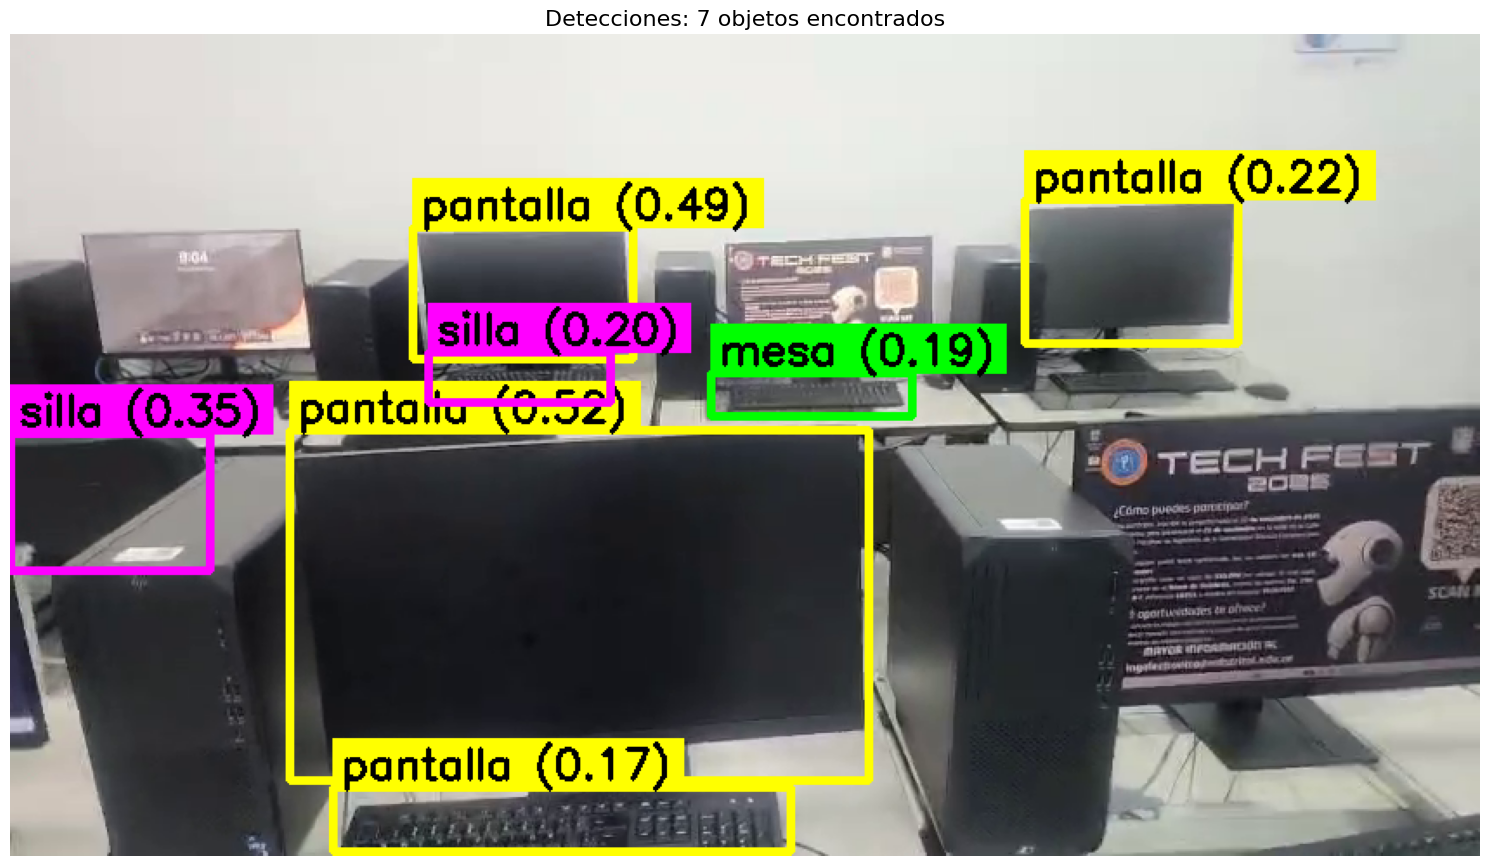

In [14]:
# Ejecutar pipeline completo
if Path(TEST_IMAGE).exists():
    detections, image_rgb = process_image_with_yolo(
        image_path=TEST_IMAGE,
        confidence_threshold=0.25,  # Ajusta si es necesario (0.1 - 0.5)
        show_details=True
    )
    
    # Visualizar resultados
    if detections:
        result_image = visualize_results(image_rgb, detections, figsize=(15, 10))

## 10. Análisis detallado de cada detección

Podemos inspeccionar cada objeto detectado individualmente:

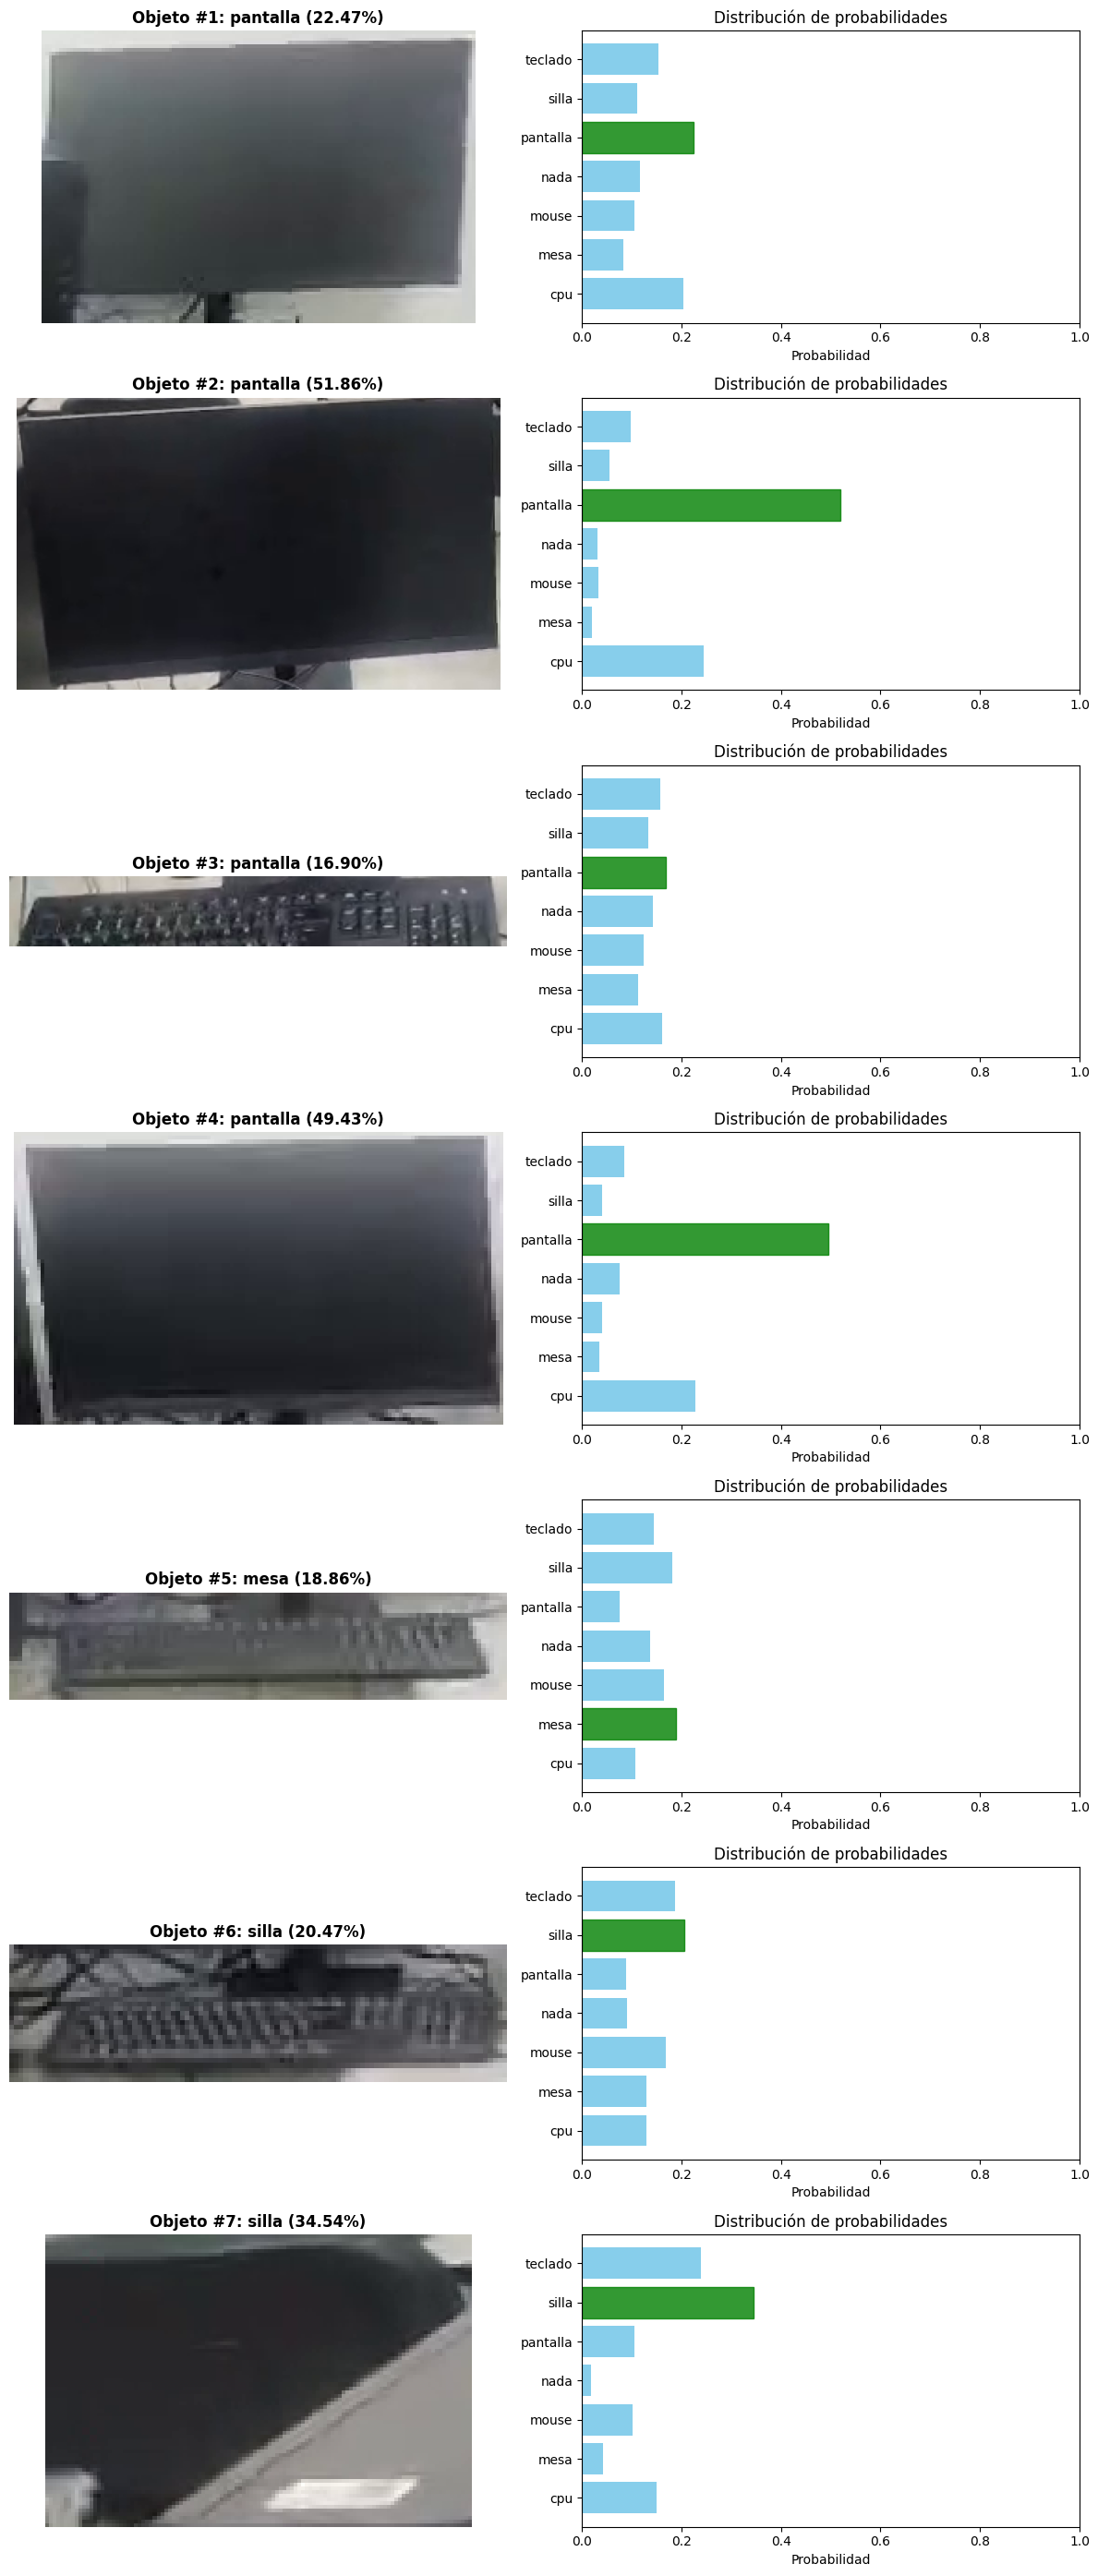

In [15]:
# Mostrar cada objeto detectado con sus probabilidades
if 'detections' in locals() and detections:
    num_dets = len(detections)
    fig, axes = plt.subplots(num_dets, 2, figsize=(12, 4 * num_dets))
    
    if num_dets == 1:
        axes = axes.reshape(1, -1)
    
    for i, det in enumerate(detections):
        # Mostrar recorte
        axes[i, 0].imshow(det['crop'])
        axes[i, 0].set_title(
            f"Objeto #{det['id']}: {det['custom_class']} ({det['custom_conf']:.2%})",
            fontsize=12, fontweight='bold'
        )
        axes[i, 0].axis('off')
        
        # Mostrar probabilidades de todas las clases
        axes[i, 1].barh(classes, det['all_probs'], color='skyblue')
        axes[i, 1].set_xlabel('Probabilidad', fontsize=10)
        axes[i, 1].set_title('Distribución de probabilidades', fontsize=12)
        axes[i, 1].set_xlim([0, 1])
        
        # Resaltar la clase predicha
        predicted_idx = classes.index(det['custom_class'])
        axes[i, 1].get_children()[predicted_idx].set_color('green')
        axes[i, 1].get_children()[predicted_idx].set_alpha(0.8)
    
    plt.tight_layout()
    plt.show()
else:
    print("No hay detecciones para visualizar")

## 11. Resumen estadístico

In [16]:
if 'detections' in locals() and detections:
    print("\n" + "="*70)
    print("RESUMEN DE DETECCIONES")
    print("="*70)
    
    # Contar por clase
    from collections import Counter
    class_counts = Counter([d['custom_class'] for d in detections])
    
    print(f"\nTotal de objetos detectados: {len(detections)}\n")
    print("Distribución por clase:")
    for cls, count in class_counts.most_common():
        print(f"  {cls}: {count}")
    
    # Confianza promedio
    avg_conf = np.mean([d['custom_conf'] for d in detections])
    print(f"\nConfianza promedio: {avg_conf:.2%}")
    
    # Detección con mayor y menor confianza
    max_conf_det = max(detections, key=lambda x: x['custom_conf'])
    min_conf_det = min(detections, key=lambda x: x['custom_conf'])
    
    print(f"\nMayor confianza: {max_conf_det['custom_class']} ({max_conf_det['custom_conf']:.2%})")
    print(f"Menor confianza: {min_conf_det['custom_class']} ({min_conf_det['custom_conf']:.2%})")
    print("="*70)


RESUMEN DE DETECCIONES

Total de objetos detectados: 7

Distribución por clase:
  pantalla: 4
  silla: 2
  mesa: 1

Confianza promedio: 30.65%

Mayor confianza: pantalla (51.86%)
Menor confianza: pantalla (16.90%)


## 12. Guardar resultados

In [17]:
# Guardar imagen con detecciones
if 'result_image' in locals():
    output_path = 'resultado_yolo_integration.jpg'
    result_bgr = cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, result_bgr)
    print(f" Resultado guardado en: {output_path}")
    
    # Guardar información de detecciones en JSON
    detections_info = []
    for det in detections:
        detections_info.append({
            'id': det['id'],
            'bbox': det['bbox'],
            'yolo_detection': {
                'class': det['yolo_class'],
                'confidence': float(det['yolo_conf'])
            },
            'custom_classification': {
                'class': det['custom_class'],
                'confidence': float(det['custom_conf'])
            }
        })
    
    with open('detections.json', 'w') as f:
        json.dump(detections_info, f, indent=2)
    
    print(" Información de detecciones guardada en: detections.json")

 Resultado guardado en: resultado_yolo_integration.jpg
 Información de detecciones guardada en: detections.json


## 13. Función helper para procesar múltiples imágenes

In [ ]:
def process_multiple_images(image_paths, confidence_threshold=0.25):
    """
    Procesa múltiples imágenes y devuelve un resumen.
    
    Args:
        image_paths: Lista de rutas de imágenes
        confidence_threshold: Umbral para YOLO
    
    Returns:
        Diccionario con resultados agregados
    """
    all_results = []
    
    for img_path in image_paths:
        if Path(img_path).exists():
            detections, image = process_image_with_yolo(
                img_path, 
                confidence_threshold=confidence_threshold,
                show_details=False
            )
            all_results.append({
                'image': img_path,
                'num_detections': len(detections),
                'detections': detections
            })
    
    return all_results

# Ejemplo de uso:
# images = ['image1.jpg', 'image2.jpg', 'image3.jpg']
# results = process_multiple_images(images)

print(" Función para procesar múltiples imágenes definida")

## 📝 Notas importantes

### ¿Cómo funciona el pipeline?

1. **YOLO (YOLOv8 Nano)**:
   - Pre-entrenado en COCO dataset (80 clases genéricas)
   - Detecta objetos genéricos: "person", "chair", "laptop", etc.
   - Proporciona bounding boxes (x, y, w, h)
   - Rápido: ~30-50 FPS en GPU, ~5-10 FPS en CPU

2. **Nuestro Clasificador**:
   - Especializado en 7 clases específicas del salón
   - Usa el autoencoder entrenado (73.77% accuracy)
   - Procesa cada recorte de 32x32 píxeles
   - Más preciso para nuestras clases específicas

### Ventajas de este enfoque:
- ✅ No necesita anotar bounding boxes
- ✅ Reutiliza tu modelo ya entrenado
- ✅ Funciona con múltiples objetos
- ✅ Fácil de implementar y mantener

### Limitaciones:
- ⚠️ YOLO puede no detectar objetos pequeños o parcialmente ocultos
- ⚠️ La precisión depende del umbral de confianza
- ⚠️ Objetos muy juntos pueden fusionarse en una detección

### Mejoras futuras:
- 🔄 Entrenar YOLOv8 con tus 7 clases específicas (mayor precisión)
- 🔄 Usar un autoencoder más grande (64x64 o 128x128)
- 🔄 Implementar seguimiento temporal (tracking) para videos
- 🔄 Agregar filtros post-procesamiento (NMS, filtrado por área, etc.)